# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [57]:
## basic functionality
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt


## can add others if you need them

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [105]:
dx = pd.read_csv("/Users/alexastrauss/QSS17W24/sentencing_asof0405.csv")

/var/folders/2d/9d8wknmx1xdb64c0myhx8fl40000gn/T/ipykernel_90402/778172925.py:1: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  dx = pd.read_csv("/Users/alexastrauss/QSS17W24/sentencing_asof0405.csv")


## 0.2: Print head, dimensions, info (0 points)

# Part one: data cleaning/interpretation

## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
    - Why there are more unique charges than unique people?

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.


In [80]:
#question 1:
columns = ['CASE_ID', 'CASE_PARTICIPANT_ID', 'CHARGE_ID']
for x in columns:
    unique_count = df[x].nunique()
    print(unique_count)

135165
135165
135165


In [ ]:
#question 2:
# There are more unique people than unique cases because there is likely a set identification for each case, and multiple unique persons
# could commit each case. There are more unique charges than unique people likely because one person can have multiple charges.

In [82]:
#question 3:
charges_percase_part = df.groupby('CASE_ID')['CHARGE_ID'/'CASE_PARTICIPANT_ID'].nunique()

mean_charges_percase_part = charges_per_case_part.mean()
median_charges_percase_part = charges_per_case_part.median()

NameError: name 'charges_per_case_part' is not defined

In [88]:
#question 4
part_percase = df.groupby('CASE_ID')['CASE_PARTICIPANT_ID'].nunique()
mean_part_percase = part_percase.mean()
median_part_percase = part_percase.median()

In [ ]:
#question 5
###########????????????/

## 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY` 

- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be


In [38]:
#question 1
# The difference is that the OFFENSE_CATEGORY is filed when the case is first created, but then because cases can change with more evidence
# due to issues such as gaining more evidence, the UPDATED_OFFENSE_CATEGORY is created when the case's category changes due to the
# case evolving.

#question 2
df['CHANGED_OFFENSE'] = df['OFFENSE_CATEGORY'] != df['UPDATED_OFFENSE_CATEGORY']
changed_offenses = df[df['CHANGED_OFFENSE']]

commonchange = changed_offenses['OFFENSE_CATEGORY'].value_counts().reset_index()
commonchange.columns = ['Original Offense', 'Count']
sortchange = commonchange.sort_values(by='Count', ascending=False)

print(sortchange)


                Original Offense  Count
0              PROMIS Conversion   6394
1                            DUI   3896
2   UUW - Unlawful Use of Weapon   2155
3                  Other Offense   2125
4             Aggravated Battery   1927
..                           ...    ...
83                       Perjury      4
84                  Prostitution      3
85    Compelling Gang Membership      2
86       Benefit Recipient Fraud      2
87             Violate Bail Bond      2

[88 rows x 2 columns]


## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [98]:
#question 1
def simplify_offense(offense):
    if offense.startswith("Aggravated"):
        return offense.replace("Aggravated ", "")
    elif "Arson" in offense:
        return "Arson"
    elif "Homicide" in offense:
        return "Homicide"
    elif "Vehicle" in offense or "Vehicular" in offense:
        return "Vehicle-related"
    elif "Battery" in offense:
        return "Battery"
    else:
        return offense
        
df['simplified_offense_derived'] = df['UPDATED_OFFENSE_CATEGORY'].map(simplify_offense)

print(df['UPDATED_OFFENSE_CATEGORY'].nunique())
print(df['simplified_offense_derived'].nunique())

#question 2
unique_og = df['UPDATED_OFFENSE_CATEGORY'].nunique()
unique_new = df['simplified_offense_derived'].nunique()
print(unique_og - unique_new)

78
66
12


## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [42]:
#question 1
df['is_black_derived'] = df['RACE'].str.contains('Black|mixed race with hispanic', case=False, na=False)
df['is_hisp_derived'] = df['RACE'].str.contains('Hispanic|white hispanic', case=False, na=False)
df['is_white_derived'] = df['RACE'].str.contains('White non-hispanic', case=False, na=False)
df['is_othereth_derived'] = ~(df['is_black_derived'] | df['is_hisp_derived'] | df['is_white_derived'])

df['is_male_derived'] = df['GENDER'].str.contains('Male', case=False, na=False)

# Clean Age at incident variable
age_upper_limit = df['AGE_AT_INCIDENT'].quantile(0.9999)
age_99_99th_percentile = df['AGE_AT_INCIDENT'].quantile(0.9999)
df['age_derived'] = np.where(df['AGE_AT_INCIDENT'] > age_upper_limit, age_99_99th_percentile, df['AGE_AT_INCIDENT'])

# Clean Sentencing Date variable
# Fix mistranscribed years
df['SENTENCING_DATE'] = df['SENTENCING_DATE'].astype(str)
df['SENTENCING_DATE'] = df['SENTENCING_DATE'].str.replace(r'291[0-9]', '2014', regex=True)
df['SENTENCING_DATE'] = df['SENTENCING_DATE'].str.replace(r'221[0-9]', '2021', regex=True)

# Convert to datetime, coercing errors
df['sentenceymd_derived'] = pd.to_datetime(df['SENTENCING_DATE'], errors='coerce')

# Filter out years after 2021
df = df[df['sentenceymd_derived'].dt.year <= 2021]

# Round down to the first of the month and year
df['sentenceym_derived'] = df['sentenceymd_derived'].dt.to_period('M').dt.to_timestamp()

# Clean Sentencing Judge variable
df['SENTENCE_JUDGE'] = df['SENTENCE_JUDGE'].astype(str)
df['SENTENCE_JUDGE'] = df['SENTENCE_JUDGE'].replace({'Doug Simpson': 'Douglas Simpson', 'Shelley Sutker': 'Shelley Sutker-Hyphenated'}, regex=True)

# Create unique judge identifier
unique_judges = df['SENTENCE_JUDGE'].unique()
unique_judge_dict = {judge: f'judge_{i+1}' for i, judge in enumerate(sorted(unique_judges))}
df['judgeid_derived'] = df['SENTENCE_JUDGE'].map(unique_judge_dict)

# Print random sample of 10 rows to validate work
print(df.sample(n=10)[['RACE', 'is_black_derived', 'is_hisp_derived', 'is_white_derived', 'is_othereth_derived', 
                        'GENDER', 'is_male_derived', 'AGE_AT_INCIDENT', 'age_derived', 
                        'SENTENCING_DATE', 'sentenceymd_derived', 'sentenceym_derived', 
                        'SENTENCE_JUDGE', 'judgeid_derived']])


KeyError: 'SENTENCING_DATE'

## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [44]:
#question 1
single_participant_cases = df.groupby('CASE_ID').filter(lambda x: len(x) == 1)

# Step 2: Subset to primary charges and current sentences
primary_charge_subset = single_participant_cases[
    (single_participant_cases['PRIMARY_CHARGE_FLAG'] == True) &
    (single_participant_cases['CURRENT_SENTENCE_FLAG'] == True)
]

# Step 3: Check for no multiple charges for the same case-participant
assert primary_charge_subset[['CASE_ID', 'CASE_PARTICIPANT_ID']].duplicated().sum() == 0, \
    "There are still multiple charges for the same case-participant."

# Step 4: Filter out observations where judge is NaN or nonsensical
cleaned_subset = primary_charge_subset[
    ~(primary_charge_subset['SENTENCE_JUDGE'].isnull() | 
      primary_charge_subset['SENTENCE_JUDGE'].str.contains('FLOOD', na=False))
]

# Step 5: Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)
date_filtered_subset = cleaned_subset[
    (cleaned_subset['sentenceymd_derived'] >= '2012-01-01') &
    (cleaned_subset['sentenceymd_derived'] <= '2021-04-05')
]

# Print the number of rows in the final data
print(f"Number of rows in the final dataset: {date_filtered_subset.shape[0]}")


KeyError: 'sentenceymd_derived'

# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [107]:
dx = pd.read_pickle("/Users/alexastrauss/QSS17W24/sentencing_cleaned.pkl")
dx.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,simplified_offense_derived,is_black_derived,is_hisp_derived,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived
9,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,27.0,2014-10-16,2014-10-01,judge_40
16,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,30.0,2014-08-06,2014-08-01,judge_310
18,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,PROMIS Conversion,False,True,False,False,True,38.0,2013-12-02,2013-12-01,judge_162
19,155222744754,217349881776,1/31/2001 12:00:00 AM,PROMIS Conversion,True,53899906462,280120721775,POSS AMT CON SUB EXCEPT (A)/(D),1,9/10/2012 12:00:00 AM,...,Narcotics,True,False,False,False,False,33.0,2012-09-10,2012-09-01,judge_331
26,155327892699,217212381455,2/6/2001 12:00:00 AM,PROMIS Conversion,True,53938518259,164877860811,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,9/19/2014 12:00:00 AM,...,PROMIS Conversion,False,False,True,False,True,49.0,2014-09-19,2014-09-01,judge_314


## 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

In [168]:
# Making a separate table for all the information

props = dx.groupby('sentenceym_derived').agg(
	total_cases=('CASE_ID', 'nunique'),  
	black_count=('is_black_derived', 'sum'),
	white_count=('is_white_derived', 'sum')
).reset_index()

props['black_proportion'] = props['black_count'] / props['total_cases']
props['white_proportion'] = props['white_count'] / props['total_cases']


import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(11, 6))

plt.plot(props['sentenceym_derived'].astype(str), props['black_proportion'], label='Black Defendants', color='#ff8080', marker='o')

plt.plot(props['sentenceym_derived'].astype(str), props['white_proportion'], label='White Defendants', color='#99ccff', marker='o')

## added in this line
#plt.plot(props2['sentenceym_derived'].astype(str), props2['smooth_diff'], label='Black Defendants', color='#ff8080')


plt.xlabel('Date')
plt.ylabel('Proportion of Defendants')
plt.title('Proportion of Defendants Over Time')

plt.legend(title='Defendant Race', loc='upper right')

#fixing x-axis issue
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

# adding the vertical line for when the attorney took office
vertical_line_date = '2016-12-01'
plt.axvline(x=vertical_line_date, color='black', linestyle='--', linewidth=1)

# trying to shade the background
for i, row in props.iterrows():
	if row['total_cases'] < 100:
    	plt.axvspan(i - 0.5, i + 0.5, color='gray', alpha=0.2)

plt.tight_layout()
plt.show()


# Math summary thing for latex 

### Black Defendants:
$
\
\frac{\sum_{n=1}^{N} \text{black\ defendants}}{\sum_{n=1}^{N} (\text{black\ defendants} + \text{white\ defendants})}
\
$

### White Defendants:
$
\
\frac{\sum_{n=1}^{N} \text{white\ defendants}}{\sum_{n=1}^{N} (\text{black\ defendants} + \text{white\ defendants})}
\
$

Analysis:
#### Trends: In May and April, the proportion of black defendants decreased drastically and the proportion of white defendants increased. This could be due to the small sample size of these particular months having less than 100 cases.


TabError: inconsistent use of tabs and spaces in indentation (<string>, line 42)

## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

,sentenceym_derived,total_cases,black_count,white_count,black_incarcerated,white_incarcerated,black_inc_percent,white_inc_percent,diff_inc,smooth_diff
0,2012-01-01,1674,1134,242,674,87,0.594356,0.359504,0.234852,NaN
1,2012-02-01,1450,941,233,566,87,0.601488,0.373391,0.228097,NaN
2,2012-03-01,1612,1030,255,602,113,0.584466,0.443137,0.141329,NaN
3,2012-04-01,1436,1000,211,598,94,0.598000,0.445498,0.152502,NaN
4,2012-05-01,1545,1074,223,579,73,0.539106,0.327354,0.211752,NaN
...,...,...,...,...,...,...,...,...,...,...
106,2020-11-01,491,298,76,122,23,0.409396,0.302632,0.106764,1.612345
107,2020-12-01,537,347,85,170,32,0.489914,0.376471,0.113443,1.336899
108,2021-01-01,447,278,50,138,22,0.496403,0.440000,0.056403,1.032985
109,2021-02-01,491,320,66,136,13,0.425000,0.196970,0.228030,1.004605


<Figure size 1100x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Difference between Black Incarceration and White Incarceration (%)')

Text(0.5, 1.0, 'Difference between Black Incarceration and White Incarceration over Time')

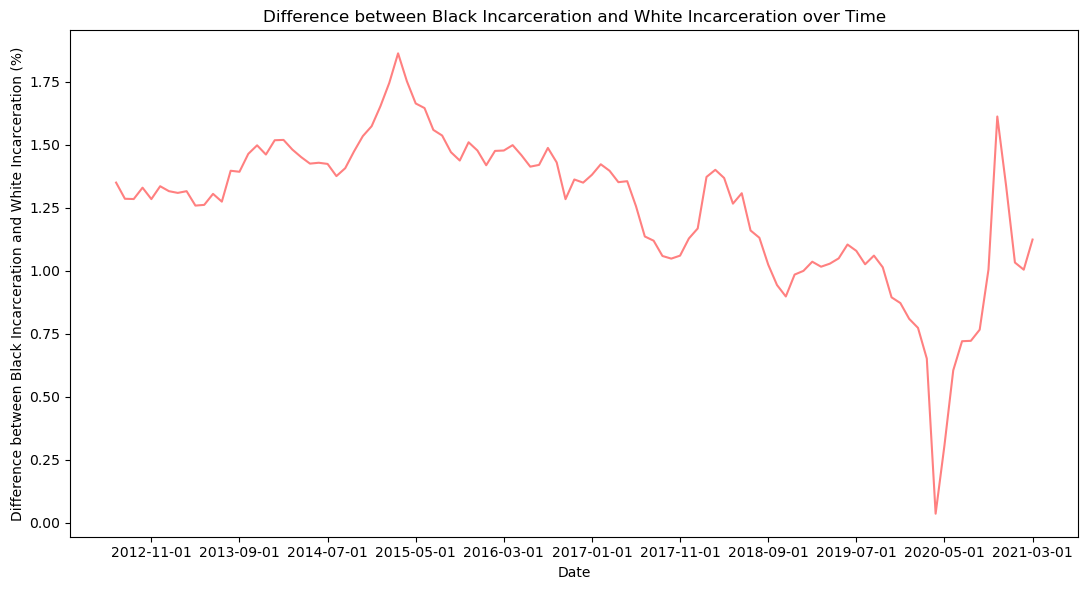

In [115]:
# new data table
props2 = dx.groupby('sentenceym_derived').agg(
	total_cases=('CASE_ID', 'nunique'),  
	black_count=('is_black_derived', 'sum'),
	white_count=('is_white_derived', 'sum'),
	black_incarcerated=('COMMITMENT_TYPE', lambda x: ((x == 'Illinois Department of Corrections') & (dx.loc[x.index, 'is_black_derived'])).sum()),
	white_incarcerated=('COMMITMENT_TYPE', lambda x: ((x == 'Illinois Department of Corrections') & (dx.loc[x.index, 'is_white_derived'])).sum()),

).reset_index()

props2['black_inc_percent'] = props2['black_incarcerated'] / props['black_count']
props2['white_inc_percent'] = props2['white_incarcerated'] / props['white_count']
props2['diff_inc'] = props2['black_inc_percent'] - props2['white_inc_percent']
# smoothed for graph using link in slides
props2['smooth_diff'] = props2['diff_inc'].rolling(7).sum()

props2

#dx['COMMITMENT_TYPE']


# Plot

plt.figure(figsize=(11, 6))

plt.plot(props2['sentenceym_derived'].astype(str), props2['smooth_diff'], label='Black Defendants', color='#ff8080')

plt.xlabel('Date')
plt.ylabel('Difference between Black Incarceration and White Incarceration (%)')
plt.title('Difference between Black Incarceration and White Incarceration over Time')

#fixing x-axis issue
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=12))

plt.tight_layout()
plt.show()


## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

<Axes: xlabel='CHARGE_ID,is_black_derived'>

Text(0.5, 1.0, 'Charge Type Distribution by Race')

Text(0.5, 0, 'Charge ID')

Text(0, 0.5, 'Proportion of Defendants')

(array([     0,      1,      2, ..., 135162, 135163, 135164]),
 [Text(0, 0, '(50510062193, True)'),
  Text(1, 0, '(50792360681, True)'),
  Text(2, 0, '(53899906462, True)'),
  Text(3, 0, '(53938518259, False)'),
  Text(4, 0, '(54885211141, False)'),
  Text(5, 0, '(55017536987, True)'),
  Text(6, 0, '(55609182331, False)'),
  Text(7, 0, '(55612048051, False)'),
  Text(8, 0, '(55731151366, True)'),
  Text(9, 0, '(56320785680, False)'),
  Text(10, 0, '(56543105166, False)'),
  Text(11, 0, '(56802075694, True)'),
  Text(12, 0, '(56883120247, False)'),
  Text(13, 0, '(57317251582, False)'),
  Text(14, 0, '(57556262626, False)'),
  Text(15, 0, '(57762242484, True)'),
  Text(16, 0, '(58023676525, True)'),
  Text(17, 0, '(58224477979, True)'),
  Text(18, 0, '(58235136444, True)'),
  Text(19, 0, '(58397124997, False)'),
  Text(20, 0, '(58424726399, True)'),
  Text(21, 0, '(58722358999, False)'),
  Text(22, 0, '(59368151356, True)'),
  Text(23, 0, '(59917464496, True)'),
  Text(24, 0, '(60018016

/var/folders/2d/9d8wknmx1xdb64c0myhx8fl40000gn/T/ipykernel_90402/2531288099.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


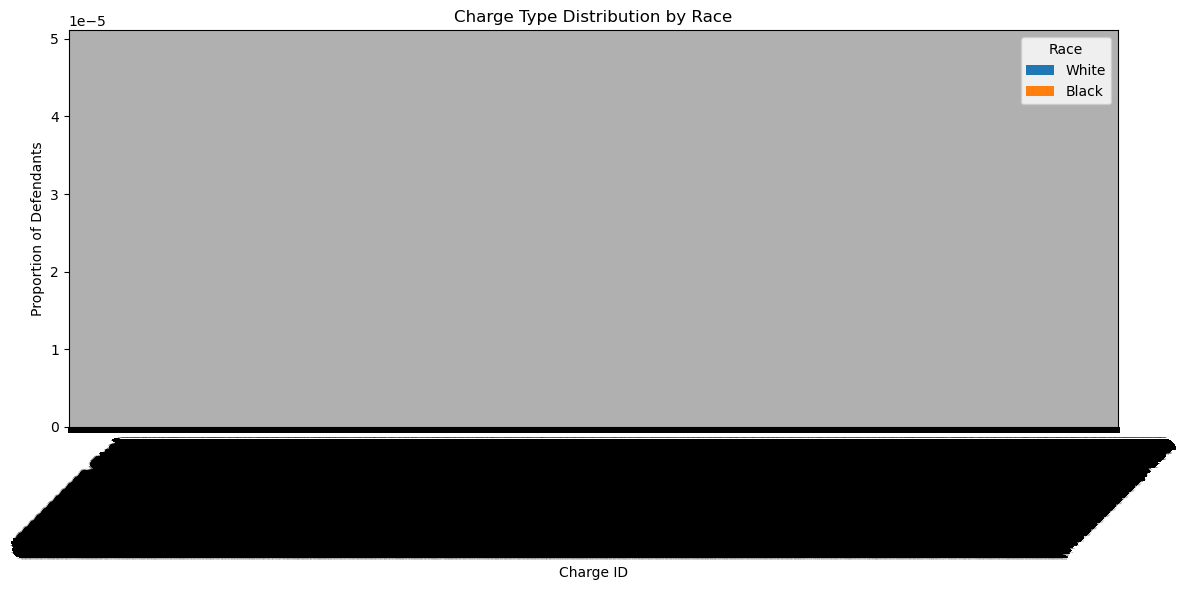

In [74]:
charge_distribution = df.groupby(['CHARGE_ID', 'is_black_derived', 'is_white_derived']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
charge_distribution_prop = charge_distribution.div(charge_distribution.sum(axis=0), axis=1)

# Print the charge distributions for further analysis
##print(charge_distribution_prop)

# Visualize the charge distributions
charge_distribution_prop.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Charge Type Distribution by Race')
plt.xlabel('Charge ID')
plt.ylabel('Proportion of Defendants')
plt.legend(title='Race', labels=['White', 'Black'])
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [117]:
black_offense_counts = dx[dx['is_black_derived']]['simplified_offense_derived'].value_counts()
ten_black = set(black_offense_counts.index[:10])
ten_black

white_offense_counts = dx[dx['is_white_derived']]['simplified_offense_derived'].value_counts()
ten_white = set(white_offense_counts.index[:10])
ten_white

top_ten = ten_black.union(ten_white)
top_ten


{'Battery',
 'Burglary',
 'DUI',
 'Driving With Suspended Or Revoked License',
 'Narcotics',
 'Retail Theft',
 'Robbery',
 'Theft',
 'UUW - Unlawful Use of Weapon',
 'Vehicle-related'}

{'Battery',
 'Burglary',
 'DUI',
 'Driving With Suspended Or Revoked License',
 'Narcotics',
 'Other Offense',
 'Residential Burglary',
 'Retail Theft',
 'Theft',
 'UUW - Unlawful Use of Weapon'}

{'Battery',
 'Burglary',
 'DUI',
 'Driving With Suspended Or Revoked License',
 'Narcotics',
 'Other Offense',
 'Residential Burglary',
 'Retail Theft',
 'Robbery',
 'Theft',
 'UUW - Unlawful Use of Weapon',
 'Vehicle-related'}

### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?


In [153]:
props3 = dx.groupby('simplified_offense_derived').agg(
	total_cases=('CASE_ID', 'nunique'),  
	black_incarcerated_offense=('COMMITMENT_TYPE', lambda x: ((x == 'Illinois Department of Corrections') & (dx.loc[x.index, 'is_black_derived'])).sum()),
	white_incarcerated_offense=('COMMITMENT_TYPE', lambda x: ((x == 'Illinois Department of Corrections') & (dx.loc[x.index, 'is_white_derived'])).sum()),

).reset_index()

props3['black_inc_percent_offense'] = props3['black_incarcerated_offense'] / props3['total_cases']
props3['white_inc_percent_offense'] = props3['white_incarcerated_offense'] / props3['total_cases']

#props3

final_table = props3[props3['simplified_offense_derived'].isin(top_ten)]
final_table


,simplified_offense_derived,total_cases,black_incarcerated_offense,white_incarcerated_offense,black_inc_percent_offense,white_inc_percent_offense
5,Battery,7432,2367,399,0.318488,0.053687
8,Burglary,6431,2514,779,0.390919,0.121132
15,DUI,12952,1556,682,0.120136,0.052656
20,Driving With Suspended Or Revoked License,8125,2596,576,0.319508,0.070892
39,Narcotics,38780,15841,1194,0.408484,0.030789
42,Other Offense,2225,423,131,0.190112,0.058876
50,Residential Burglary,3688,1638,469,0.444143,0.127169
51,Retail Theft,10546,4058,1128,0.384790,0.106960
52,Robbery,2997,1527,132,0.509510,0.044044
56,Theft,4386,1015,349,0.231418,0.079571


### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


   Bandwidth    Pre-Gap    Post-Gap     Pre-STD    Post-STD
0          2  85.445882  107.222460  2215.76632  2215.76632
1          4  55.917158   98.074136  2215.76632  2215.76632
2          8  35.515334   62.084200  2215.76632  2215.76632
3         12  24.319710   51.179000  2215.76632  2215.76632


<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

<ErrorbarContainer object of 3 artists>

Text(0.5, 0, 'Bandwidth (Months)')

Text(0, 0.5, 'Black-White Incarceration Gap')

Text(0.5, 1.0, 'Disparities in Incarceration Rates Before and After Policy Change')

[Text(0, 0, '2'), Text(1, 0, '4'), Text(2, 0, '8'), Text(3, 0, '12')]

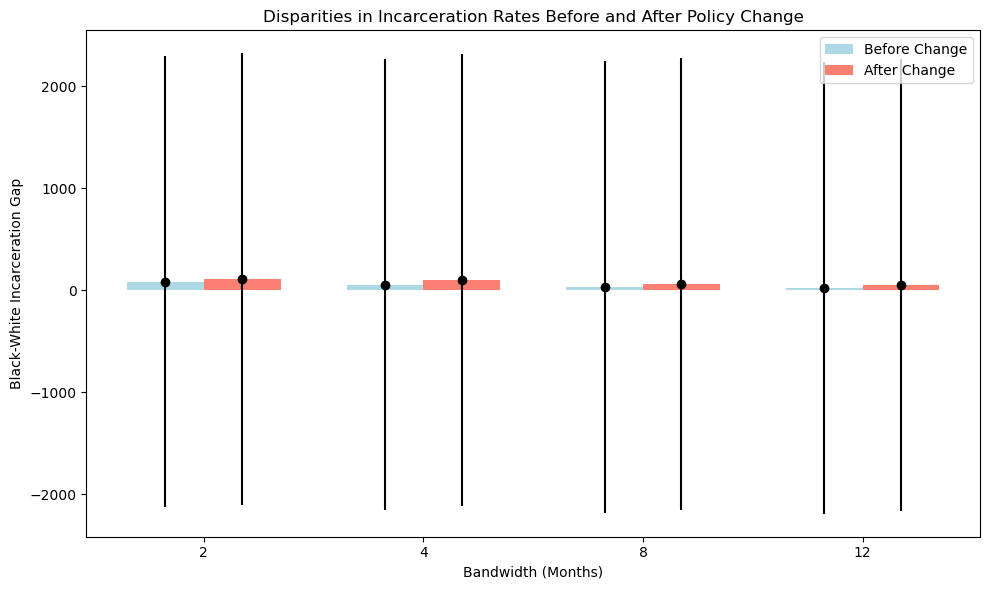

In [194]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dx is your DataFrame
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

# Define bandwidths for comparison
bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]
}

timeperiods = bandwidths.keys()
centraltime = datetime(2016, 12, 1)

# Filter for retail theft cases
retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

# Function to calculate standard deviation
std_dev = lambda x: x.std() if len(x) > 0 else float('nan')

beforeperiod = []
afterperiod = []
pre_stddev = []
post_stddev = []

# Loop through each bandwidth
for t in timeperiods:
    cut_upper = centraltime + timedelta(days=31) + timedelta(days=(t + 1) * 30)
    cut_lower = centraltime - timedelta(days=t * 30)
    cut_lower, cut_upper = cut_lower.replace(day=1), cut_upper.replace(day=1)
    
    # Filter data for pre and post periods
    firstretail = retail_theft[(retail_theft.sentenceym_derived >= cut_lower) & (retail_theft.sentenceym_derived <= centraltime)]
    secondretail = retail_theft[(retail_theft.sentenceym_derived >= datetime(2017, 1, 1)) & (retail_theft.sentenceym_derived <= cut_upper)]
    
    # Calculate gaps for Black and White incarceration rates
    case1 = ((props3.black_incarcerated_offense.sum() / firstretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / firstretail.is_white_derived.sum())) if firstretail.is_black_derived.sum() > 0 and firstretail.is_white_derived.sum() > 0 else float('nan')
    
    case2 = ((props3.black_incarcerated_offense.sum() / secondretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / secondretail.is_white_derived.sum())) if secondretail.is_black_derived.sum() > 0 and secondretail.is_white_derived.sum() > 0 else float('nan')

    # Count total cases for each group
    firstpart = firstretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    secondpart = secondretail.is_black_derived.sum() + secondretail.is_white_derived.sum()
    
    # Store results
    beforeperiod.append(case1)
    afterperiod.append(case2)
    
    # Calculate standard deviations for the gaps
    pre_std = std_dev(props3.black_incarcerated_offense) if firstretail.is_black_derived.sum() > 0 else float('nan')
    post_std = std_dev(props3.black_incarcerated_offense) if secondretail.is_black_derived.sum() > 0 else float('nan')

    pre_stddev.append(pre_std)
    post_stddev.append(post_std)

# Create a results DataFrame
results_df = pd.DataFrame({
    'Bandwidth': timeperiods,
    'Pre-Gap': beforeperiod,
    'Post-Gap': afterperiod,
    'Pre-STD': pre_stddev,
    'Post-STD': post_stddev
})

print(results_df)

# Create a bar chart to visualize the disparities
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df['Bandwidth']))
width = 0.35

# Pre-Gap bars
bars1 = ax.bar([i - width/2 for i in x], results_df['Pre-Gap'], width, label='Before Change', color='lightblue', capsize=5)
# Post-Gap bars
bars2 = ax.bar([i + width/2 for i in x], results_df['Post-Gap'], width, label='After Change', color='salmon', capsize=5)

# Adding standard deviation markers
for bar, std in zip(bars1, results_df['Pre-STD']):
    ax.errorbar(bar.get_x() + bar.get_width()/2, bar.get_height(), yerr=std, fmt='o', color='black')

for bar, std in zip(bars2, results_df['Post-STD']):
    ax.errorbar(bar.get_x() + bar.get_width()/2, bar.get_height(), yerr=std, fmt='o', color='black')

ax.set_xlabel('Bandwidth (Months)')
ax.set_ylabel('Black-White Incarceration Gap')
ax.set_title('Disparities in Incarceration Rates Before and After Policy Change')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Bandwidth'])
ax.legend()

plt.tight_layout()
plt.show()


   Bandwidth    Pre-Gap    Post-Gap  Pre-SE  Post-SE
0          2  85.445882  107.222460     NaN      NaN
1          4  55.917158   98.074136     NaN      NaN
2          8  35.515334   62.084200     NaN      NaN
3         12  24.319710   51.179000     NaN      NaN


/var/folders/2d/9d8wknmx1xdb64c0myhx8fl40000gn/T/ipykernel_90402/3328826487.py:23: RuntimeWarning: invalid value encountered in scalar power
  forcheck = lambda p, n: (((p * (1 - p)) / n) ** 0.5) if n > 0 else float('nan')


<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Bandwidth (Months)')

Text(0, 0.5, 'Black-White Incarceration Gap')

Text(0.5, 1.0, 'Disparities in Incarceration Rates Before and After Policy Change')

[Text(0, 0, '2'), Text(1, 0, '4'), Text(2, 0, '8'), Text(3, 0, '12')]

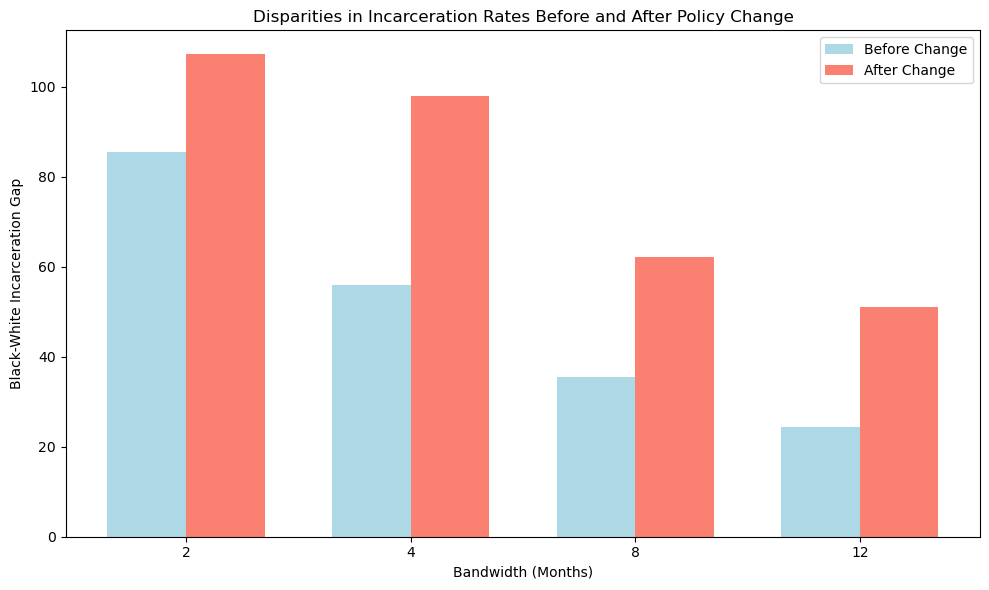

In [176]:
from datetime import datetime, timedelta

# Ensure 'sentenceym_derived' is a datetime column
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

# Define bandwidths for comparison
bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]
}

timeperiods = bandwidths.keys()
centraltime = datetime(2016, 12, 1)

# Filter for retail theft cases
retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

# Function to calculate standard error
forcheck = lambda p, n: (((p * (1 - p)) / n) ** 0.5) if n > 0 else float('nan')

beforeperiod = []
afterperiod = []
preforecheck = []
aftforecheck = []

# Loop through each bandwidth
for t in timeperiods:
    cut_upper = centraltime + timedelta(days=31) + timedelta(days=(t + 1) * 30)
    cut_lower = centraltime - timedelta(days=t * 30)
    cut_lower, cut_upper = cut_lower.replace(day=1), cut_upper.replace(day=1)
    
    # Filter data for pre and post periods
    firstretail = retail_theft[(retail_theft.sentenceym_derived >= cut_lower) & (retail_theft.sentenceym_derived <= centraltime)]
    secondretail = retail_theft[(retail_theft.sentenceym_derived >= datetime(2017, 1, 1)) & (retail_theft.sentenceym_derived <= cut_upper)]
    
    # Calculate gaps for Black and White incarceration rates
    case1 = ((props3.black_incarcerated_offense.sum() / firstretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / firstretail.is_white_derived.sum())) if firstretail.is_black_derived.sum() > 0 and firstretail.is_white_derived.sum() > 0 else float('nan')
    
    case2 = ((props3.black_incarcerated_offense.sum() / secondretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / secondretail.is_white_derived.sum())) if secondretail.is_black_derived.sum() > 0 and secondretail.is_white_derived.sum() > 0 else float('nan')

    # Count total cases for each group
    firstpart = firstretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    secondpart = secondretail.is_black_derived.sum() + secondretail.is_white_derived.sum()
    
    # Store results
    beforeperiod.append(case1)
    afterperiod.append(case2)
    
    # Calculate standard errors for the gaps
    pre_se = forcheck(case1, firstpart) if not pd.isna(case1) else float('nan')
    post_se = forcheck(case2, secondpart) if not pd.isna(case2) else float('nan')
    
    preforecheck.append(pre_se)
    aftforecheck.append(post_se)

# Create a results DataFrame
results_df = pd.DataFrame({
    'Bandwidth': timeperiods,
    'Pre-Gap': beforeperiod,
    'Post-Gap': afterperiod,
    'Pre-SE': preforecheck,
    'Post-SE': aftforecheck
})

print(results_df)

# Create a bar chart to visualize the disparities
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df['Bandwidth']))
width = 0.35

# Pre-Gap bars
ax.bar([i - width/2 for i in x], results_df['Pre-Gap'], width, yerr=results_df['Pre-SE'], label='Before Change', color='lightblue')
# Post-Gap bars
ax.bar([i + width/2 for i in x], results_df['Post-Gap'], width, yerr=results_df['Post-SE'], label='After Change', color='salmon')

ax.set_xlabel('Bandwidth (Months)')
ax.set_ylabel('Black-White Incarceration Gap')
ax.set_title('Disparities in Incarceration Rates Before and After Policy Change')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Bandwidth'])
ax.legend()

plt.tight_layout()
plt.show()


   Bandwidth    Pre-Gap    Post-Gap  Pre-SE  Post-SE
0          2  85.445882  107.222460     NaN      NaN
1          4  55.917158   98.074136     NaN      NaN
2          8  35.515334   62.084200     NaN      NaN
3         12  24.319710   51.179000     NaN      NaN


/var/folders/2d/9d8wknmx1xdb64c0myhx8fl40000gn/T/ipykernel_90402/638166923.py:21: RuntimeWarning: invalid value encountered in scalar power
  forcheck = lambda p, n: (((p * (1 - p)) / n) ** 0.5) if n > 0 else 0


<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Bandwidth (Months)')

Text(0, 0.5, 'Black-White Incarceration Gap')

Text(0.5, 1.0, 'Disparities in Incarceration Rates Before and After Policy Change')

[Text(0, 0, '2'), Text(1, 0, '4'), Text(2, 0, '8'), Text(3, 0, '12')]

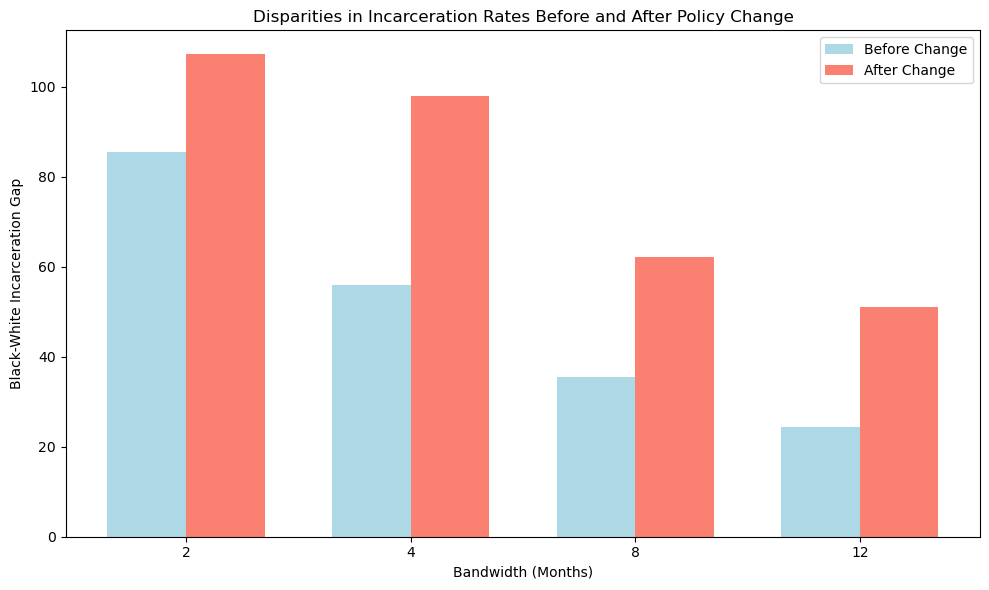

In [170]:
from datetime import datetime, timedelta

dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

#bandwidths periods defined
bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]
}

timeperiods = bandwidths.keys()
centraltime = datetime(2016, 12, 1)

#filter for retail theft cases
retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

#to find the extra credit standard error
forcheck = lambda p, n: (((p * (1 - p)) / n) ** 0.5) if n > 0 else 0

#lists to be filled
beforeperiod = []
afterperiod = []
preforecheck = []
aftforecheck = []

#to go through each bandwidth time period
for t in timeperiods:
    cut_upper = centraltime + timedelta(days=31) + timedelta(days=(t + 1) * 30)
    cut_lower = centraltime - timedelta(days=t * 30)
    cut_lower, cut_upper = cut_lower.replace(day=1), cut_upper.replace(day=1)
    
    #data for pre and post periods
    firstretail = retail_theft[(retail_theft.sentenceym_derived >= cut_lower) & (retail_theft.sentenceym_derived <= centraltime)]
    secondretail = retail_theft[(retail_theft.sentenceym_derived >= datetime(2017, 1, 1)) & (retail_theft.sentenceym_derived <= cut_upper)]
    
    #gaps for Black and White incarceration rates
    case1 = ((props3.black_incarcerated_offense.sum() / firstretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / firstretail.is_white_derived.sum())) if firstretail.is_black_derived.sum() > 0 and firstretail.is_white_derived.sum() > 0 else float('nan')
    
    case2 = ((props3.black_incarcerated_offense.sum() / secondretail.is_black_derived.sum()) -
             (props3.white_incarcerated_offense.sum() / secondretail.is_white_derived.sum())) if secondretail.is_black_derived.sum() > 0 and secondretail.is_white_derived.sum() > 0 else float('nan')

    #total cases for each group
    firstpart = firstretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    secondpart = secondretail.is_black_derived.sum() + secondretail.is_white_derived.sum()
    
    #results
    beforeperiod.append(case1)
    afterperiod.append(case2)
    preforecheck.append(forcheck(case1, firstpart))
    aftforecheck.append(forcheck(case2, secondpart))

#Dataframe for results
results_df = pd.DataFrame({
    'Bandwidth': timeperiods,
    'Pre-Gap': beforeperiod,
    'Post-Gap': afterperiod,
    'Pre-SE': preforecheck,
    'Post-SE': aftforecheck
})

print(results_df)

# Create a bar chart to visualize the disparities
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df['Bandwidth']))
width = 0.35

# Pre-Gap bars
ax.bar([i - width/2 for i in x], results_df['Pre-Gap'], width, yerr=results_df['Pre-SE'], label='Before Change', color='lightblue')
# Post-Gap bars
ax.bar([i + width/2 for i in x], results_df['Post-Gap'], width, yerr=results_df['Post-SE'], label='After Change', color='salmon')

ax.set_xlabel('Bandwidth (Months)')
ax.set_ylabel('Black-White Incarceration Gap')
ax.set_title('Disparities in Incarceration Rates Before and After Policy Change')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Bandwidth'])
ax.legend()

plt.tight_layout()
plt.show()

In [172]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'sentenceym_derived' is a datetime column
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

# Define bandwidths for comparison
bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]
}

timeperiods = bandwidths.keys()
centraltime = datetime(2016, 12, 1)

# Filter for retail theft cases
retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

# Function to calculate standard error
forcheck = lambda p, n: (((p * (1 - p)) / n) ** 0.5) if n > 0 else float('nan')

beforeperiod = []
afterperiod = []
preforecheck = []
aftforecheck = []

# Loop through each bandwidth
for t in timeperiods:
    cut_upper = centraltime + timedelta(days=31) + timedelta(days=(t + 1) * 30)
    cut_lower = centraltime - timedelta(days=t * 30)
    cut_lower, cut_upper = cut_lower.replace(day=1), cut_upper.replace(day=1)
    
    # Filter data for pre and post periods
    firstretail = retail_theft[(retail_theft.sentenceym_derived >= cut_lower) & (retail_theft.sentenceym_derived <= centraltime)]
    secondretail = retail_theft[(retail_theft.sentenceym_derived >= datetime(2017, 1, 1)) & (retail_theft.sentenceym_derived <= cut_upper)]
    
    # Calculate gaps for Black and White incarceration rates
    black_incarcerated_pre = firstretail.loc[firstretail.is_black_derived, 'incarcerated'].sum()
    white_incarcerated_pre = firstretail.loc[firstretail.is_white_derived, 'incarcerated'].sum()
    
    black_incarcerated_post = secondretail.loc[secondretail.is_black_derived, 'incarcerated'].sum()
    white_incarcerated_post = secondretail.loc[secondretail.is_white_derived, 'incarcerated'].sum()

    # Calculate case gaps with checks
    case1 = (black_incarcerated_pre / firstretail.is_black_derived.sum() - 
              white_incarcerated_pre / firstretail.is_white_derived.sum()) if firstretail.is_black_derived.sum() > 0 and firstretail.is_white_derived.sum() > 0 else float('nan')
    
    case2 = (black_incarcerated_post / secondretail.is_black_derived.sum() - 
              white_incarcerated_post / secondretail.is_white_derived.sum()) if secondretail.is_black_derived.sum() > 0 and secondretail.is_white_derived.sum() > 0 else float('nan')

    # Count total cases for each group
    firstpart = firstretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    secondpart = secondretail.is_black_derived.sum() + secondretail.is_white_derived.sum()

    # Store results
    beforeperiod.append(case1)
    afterperiod.append(case2)
    
    # Calculate standard errors for the gaps using the formula provided
    pre_se = forcheck(case1, firstpart) if not pd.isna(case1) else float('nan')
    post_se = forcheck(case2, secondpart) if not pd.isna(case2) else float('nan')
    
    preforecheck.append(pre_se)
    aftforecheck.append(post_se)

# Create a results DataFrame
results_df = pd.DataFrame({
    'Bandwidth': timeperiods,
    'Pre-Gap': beforeperiod,
    'Post-Gap': afterperiod,
    'Pre-SE': preforecheck,
    'Post-SE': aftforecheck
})

print(results_df)

# Create a bar chart to visualize the disparities
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results_df['Bandwidth']))
width = 0.35

# Pre-Gap bars
ax.bar([i - width/2 for i in x], results_df['Pre-Gap'], width, yerr=results_df['Pre-SE'], label='Before Change', color='lightblue')
# Post-Gap bars
ax.bar([i + width/2 for i in x], results_df['Post-Gap'], width, yerr=results_df['Post-SE'], label='After Change', color='salmon')

ax.set_xlabel('Bandwidth (Months)')
ax.set_ylabel('Black-White Incarceration Gap')
ax.set_title('Disparities in Incarceration Rates Before and After Policy Change')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Bandwidth'])
ax.legend()

plt.tight_layout()
plt.show()


KeyError: 'incarcerated'

In [178]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dx is your DataFrame
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

# Define bandwidths for comparison
bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]
}

timeperiods = bandwidths.keys()
centraltime = datetime(2016, 12, 1)

# Filter for retail theft cases
retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

# Function to calculate standard deviation
std_dev = lambda x: x.std() if len(x) > 0 else float('nan')

beforeperiod = []
afterperiod = []
pre_stddev = []
post_stddev = []

# Loop through each 


2016-10-01 00:00:00 2016-12-01 00:00:00 2017-01-01 00:00:00 2017-04-01 00:00:00
2016-08-01 00:00:00 2016-12-01 00:00:00 2017-01-01 00:00:00 2017-05-01 00:00:00
2016-04-01 00:00:00 2016-12-01 00:00:00 2017-01-01 00:00:00 2017-09-01 00:00:00
2015-12-01 00:00:00 2016-12-01 00:00:00 2017-01-01 00:00:00 2018-01-01 00:00:00


(0.0, 1.0)

KeyError: 'timeperiods'

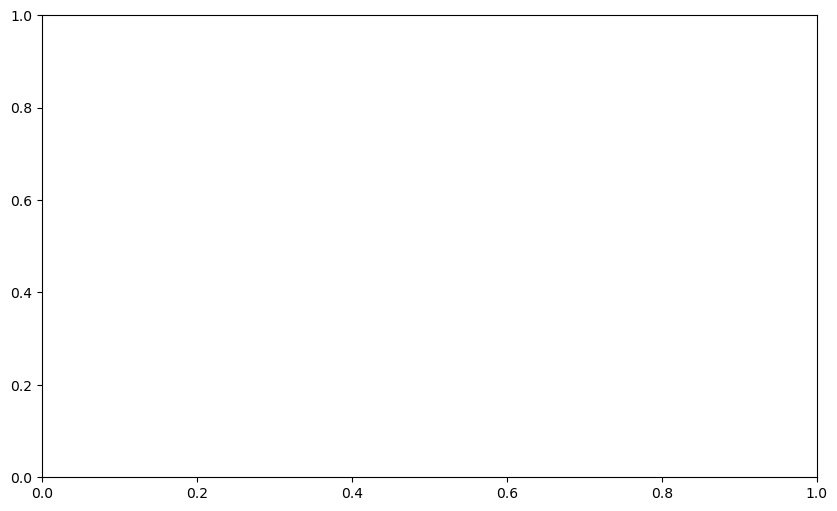

In [184]:
#convert time format
from datetime import datetime, timedelta
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

#def calc_disparity(data, pre_start, pre_end, post_start, post_end):
    #pre_data = data[(data['sentenceym_derived'] >= pre_start) & (data['sentenceym_derived'] <= pre_end)]
    #post_data = data[(data['sentenceym_derived'] >= post_start) & (data['sentenceym_derived'] <= post_end)]
    
    #pre_total_black = pre_data[pre_data['is_black_derived']].shape[0]
    #pre_incarcerated_black = pre_data[(pre_data['is_black_derived']) & (pre_data['COMMITMENT_TYPE'] == 'Illinois Department of Corrections')].shape[0]
    #post_total_black = post_data[post_data['is_black_derived']].shape[0]
    #post_incarcerated_black = post_data[(post_data['is_black_derived']) & (post_data['COMMITMENT_TYPE'] == 'Illinois Department of Corrections')].shape[0]
    
    #pre_total_white = pre_data[pre_data['is_white_derived']].shape[0]
    #pre_incarcerated_white = pre_data[(pre_data['is_white_derived']) & (pre_data['COMMITMENT_TYPE'] == 'Illinois Department of Corrections')].shape[0]
    #post_total_white = post_data[post_data['is_white_derived']].shape[0]
    #post_incarcerated_white = post_data[(post_data['is_white_derived']) & (post_data['COMMITMENT_TYPE'] == 'Illinois Department of Corrections')].shape[0]

    #pre_black_rate = pre_incarcerated_black / pre_total_black if pre_total_black > 0 else 0
    #post_black_rate = post_incarcerated_black / post_total_black if post_total_black > 0 else 0
    #pre_white_rate = pre_incarcerated_white / pre_total_white if pre_total_white > 0 else 0
    #post_white_rate = post_incarcerated_white / post_total_white if post_total_white > 0 else 0
    
    #pre_gap = pre_black_rate - pre_white_rate
    #post_gap = post_black_rate - post_white_rate
    
    #return (pre_gap, post_gap)

#the time periods
from datetime import datetime, timedelta
dx['sentenceym_derived'] = pd.to_datetime(dx['sentenceym_derived'])

bandwidths = {
    2: [('2016-10-01', '2016-11-30'), ('2017-01-01', '2017-02-28')],
    
    4: [('2016-08-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    
    8: [('2016-04-01', '2016-11-30'), ('2017-01-01', '2017-04-30')],
    
    12: [('2015-12-01', '2016-11-30'), ('2017-01-01', '2017-12-31')]}

timeperiods = bandwidths.keys()

centraltime = datetime(2016,12,1)

retail_theft = dx[dx.simplified_offense_derived == "Retail Theft"]

forcheck = lambda p, n:(((p*1-p))/n)**0.5

beforeperiod = []
afterperiod = []

preforecheck = []
aftforecheck = []

for t in timeperiods:
    cut_upper = centraltime + timedelta(days = 31, ) + timedelta(days = (t+1)*30, )
    cut_lower = centraltime - timedelta(days = t*30)
    cut_lower, cut_upper = cut_lower.replace(day=1), cut_upper.replace(day=1)
    print(cut_lower, centraltime, datetime(2017, 1, 1), cut_upper)
    
    firstretail = retail_theft[(retail_theft.sentenceym_derived >= cut_lower) & (retail_theft.sentenceym_derived <= centraltime)]
    secondretail = retail_theft[(retail_theft.sentenceym_derived >= datetime(2017,1,1)) & (retail_theft.sentenceym_derived <= cut_upper)]
    case1 = ((props3.black_incarcerated_offense.sum()/firstretail.is_black_derived.sum())-
             props3.white_incarcerated_offense.sum()/firstretail.is_white_derived.sum())
    case2 = ((props3.black_incarcerated_offense.sum()/secondretail.is_black_derived.sum())-
             props3.white_incarcerated_offense.sum()/secondretail.is_white_derived.sum())

    firstpart = firstretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    secondpart = secondretail.is_black_derived.sum() + firstretail.is_white_derived.sum()
    
    beforeperiod.append(case1)
    afterperiod.append(case2)
    preforecheck.append(forcheck(case1, firstpart))
    aftforecheck.append(forcheck(case2, secondpart))


#for time periods
#for bw, (pre, post) in bandwidths.items():
    #pre_start, pre_end = pd.to_datetime(pre)
    #post_start, post_end = pd.to_datetime(post)
    #pre_gap, post_gap = calc_disparity(retail_theft_data, pre_start, pre_end, post_start, post_end)
    #results.append((bw, pre_gap, post_gap))
#results_df = pd.DataFrame(results, columns=['Bandwidth', 'Pre-Gap', 'Post-Gap'])
#print(results_df)


ax.set_ylim(0, 1)
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df['timeperiods']))
width = 0.3
ax.bar(x - width/2, results_df['Pre-Gap'], width, label='Before Change', color='lightblue')
ax.bar(x + width/2, results_df['Post-Gap'], width, label='After Change', color='salmon')
ax.set_xlabel('Bandwidth (Months)')
ax.set_ylabel('Black-White Incarceration Gap')
ax.set_title('Disparities in Incarceration Rates Before and After Policy Change')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Bandwidth'])
ax.legend()
plt.tight_layout()
plt.show()

### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 